In [1]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm

from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
import IPython.display as disp

In [3]:
warnings.filterwarnings('ignore')

In [4]:
EXP_NAME = "EXP_002_convnext-t_224_mult"

WANDB_PROJECT = 'kaggle-corn-2022'

CSV_PATH = Path('/data/train.csv')
DATA_PATH = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


model_name = "convnext_tiny_in22ft1k"
global_pool = "catavgmax"
bsz = 32
input_sz = 224
drop_rate = 0.5
drop_path_rate = 0.1

loss_weights = [0.7, 0.3]

In [5]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [6]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [7]:
def get_dls(fold:int, size:int, bs:int):
    
    item_tfms = [Resize(size, method=ResizeMethod.Squish), ToTensor]
    
    batch_tfms = [
        IntToFloatTensor,
        *aug_transforms(flip_vert=True, max_rotate=360, max_zoom=1.3, 
                       max_lighting=0.1, p_lighting=0.5, pad_mode=PadMode.Zeros,
                       xtra_tfms=[RandomErasing(p=0.75)]),
        Normalize.from_stats(*imagenet_stats)]
    
    getters = [
           ColReader('image', pref=DATA_PATH),
           ColReader('label'),
           ColReader('view')]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS), CategoryBlock(vocab=VIEWS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        getters    = getters,
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms,
        n_inp      = 1)
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

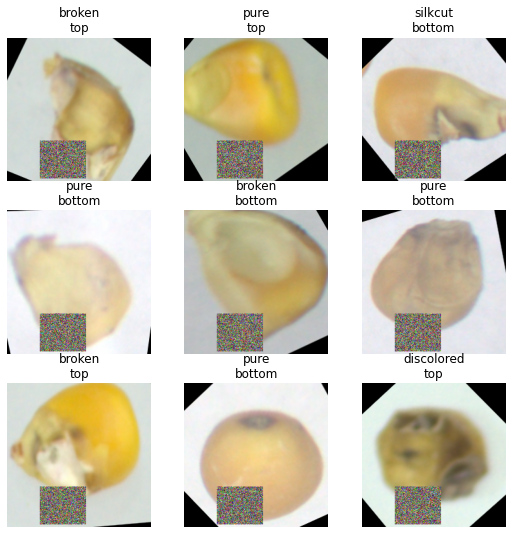

In [8]:
dls = get_dls(0, size=input_sz, bs=bsz)
_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(ctxs=axs.flatten())

In [9]:
class MultiHead(Module):
    def __init__(self, nf:int, n_out:L):
        store_attr()
        
        self.global_pool = SelectAdaptivePool2d(pool_type=global_pool, flatten=True)
        self.nf *= self.global_pool.feat_mult()
        
        self.label = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(self.nf, self.n_out[0]))
        self.view = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(self.nf, self.n_out[1]))
    
    def forward(self, x):
        y = self.global_pool(x)
        label = self.label(y)
        view = self.view(y)
        return [label, view]
        

class CornModel(Module):
    def __init__(self, n_out:L, pretrained:bool=True):
        
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            drop_path_rate=drop_path_rate,
            global_pool="",
            num_classes=0)
        
        if hasattr(self.model, 'head'):
            self.model.head = nn.Identity() 
        
        self.num_features = self.model.num_features
        
        self.head = MultiHead(self.num_features, n_out)
    
    def forward(self, x):        
        y = self.model.forward_features(x)        
        label, view = self.head(y)
        return [label, view]

In [10]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())

# def timm_params(timm_model, cut=-1):
#     body_param_names = timm_get_param_names(timm_model)
#     head_param_names = L(body_param_names.pop(-1)).concat()
    
#     body_param_names = L(body_param_names[:cut].concat(), body_param_names[cut:].concat())
#     return body_param_names, head_param_names

# def timm_splitter(m, cut=-1):
#     "Splitter function for timm models"
#     body_param_names, head_param_names = timm_params(m, cut)
#     param_groups = [g.map(m.get_parameter) for g in body_param_names]
#     param_groups.append([m.get_parameter(p) for p in head_param_names])
#     return param_groups

def get_splitter(m, cut=-1):
    body_param_names = timm_get_param_names(m.model)
    body_param_names = L(body_param_names[:cut].concat(), body_param_names[cut:].concat())
    param_groups = [g.map(m.model.get_parameter) for g in body_param_names]
    param_groups.append(params(m.head))
    return param_groups

In [11]:
#s = get_splitter(CornModel([4,2]))
# s[0]

In [12]:
class CombinationLoss(Module):
    "Cross Entropy Loss on multiple targets"
    def __init__(self, losses=[CrossEntropyLossFlat(), CrossEntropyLossFlat()], weights=[2, 1]):
        store_attr()
        assert len(self.losses) == len(self.weights)

    def forward(self, xs, *ys, reduction='mean'):
        for i, w, x, y, lf in zip(range(len(xs)), self.weights, xs, ys, self.losses):
            if i == 0: loss = w*lf(x, y) 
            else: loss += w*lf(x, y) 
        return loss/sum(self.weights)

In [13]:
@delegates(Learner)
def create_learner(dls, pretrained=True, **kwargs):
    
    set_fast_norm()
    model = CornModel(n_out=dls.c, pretrained=pretrained)
    
    learn = Learner(dls, model, **kwargs)    
    return learn

In [14]:
@delegates(create_learner)
def run_lr_finder(**kwargs):
    set_seed(42)
    
    dls = get_dls(0, size=input_sz, bs=bsz)
    m = CornModel(n_out=dls.c, pretrained=True)
    
    learn = create_learner(dls, **kwargs).to_fp16()
    learn.freeze()
    
    suggest = learn.lr_find()
    print("* Suggestion: ", suggest)

In [15]:
# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True): 
#     run_lr_finder(pretrained=True, opt_func=Adam, splitter=partial(get_splitter, cut=-3),
#         loss_func=CombinationLoss([CrossEntropyLossFlat(), CrossEntropyLossFlat()], weights=loss_weights), 
#         model_dir=Path("/runs/"))

In [24]:
@delegates(Learner.fit_flat_cos)
def finetune_fit_flat_cos(fold: int, suffix: str = "", splitter=get_splitter, 
                          opt_func=ranger, n_epoch:int = 10, **kwargs):
    """Finetunes fastai `Learner` using `fit_flat_cos`"""
    set_seed(42); set_fast_norm()
    
    dls = get_dls(fold, size=input_sz, bs=bsz)
    m = CornModel(n_out=dls.c, pretrained=True)
    
    learner_args = dict(opt_func=opt_func, splitter=splitter,
        loss_func=CombinationLoss([CrossEntropyLossFlat(), CrossEntropyLossFlat()], weights=loss_weights),
        model_dir=Path("/runs/"), metrics=[ComboAccuracy(0)])
    
    learn = create_learner(dls, pretrained=True, **learner_args).to_fp16()
    learn.unfreeze()
    learn.fit_flat_cos(n_epoch, **kwargs)
    
    learn = learn.load("model")
    learn = learn.to_fp32()
    
    learn.save(f"{EXP_NAME}_{suffix}_CV_{fold:02d}", with_opt=False)
    
    return


@delegates(Learner.fine_tune)
def finetune_one_cycle(fold: int, suffix: str = "", splitter=get_splitter, opt_func=Adam, 
                       epochs:int = 10, **kwargs):
    """Finetunes fastai `Learner` using `fine_tune`"""
    set_seed(42); set_fast_norm()
    
    dls = get_dls(fold, size=input_sz, bs=bsz)
    m = CornModel(n_out=dls.c, pretrained=True)
    
    learner_args = dict(opt_func=opt_func, splitter=splitter,
        loss_func=CombinationLoss([CrossEntropyLossFlat(), CrossEntropyLossFlat()], weights=loss_weights),
        model_dir=Path("/runs/"), metrics=[accuracy_label])
    
    learn = create_learner(dls, pretrained=True, **learner_args).to_fp16()
    learn.fine_tune(epochs=epochs, **kwargs)
    
    learn = learn.load("model")
    learn = learn.to_fp32()
    
    learn.save(f"{EXP_NAME}_{suffix}_CV_{fold:02d}", with_opt=False)
    
    return

## 10 epochs

In [17]:
def accuracy_label(inp, targ1, targ2, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ1)
    return (pred == targ).float().mean()

In [18]:
SUFFIX = "epo10_ft"

In [27]:
for fold_idx in range(5):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        cbs = [SaveModelCallback(monitor="accuracy_label", comp=np.greater)]
        finetune_one_cycle(fold_idx,opt_func=Adam, splitter=partial(get_splitter, cut=-3),
                           epochs=10,base_lr=1e-03,cbs=cbs,suffix=SUFFIX)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.483706,0.910413,0.527051,00:27


Better model found at epoch 0 with accuracy_label value: 0.5270506143569946.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.795939,0.528005,0.703665,00:37
1,0.659356,0.451867,0.747993,00:37
2,0.581557,0.427453,0.761606,00:37
3,0.549706,0.409868,0.773822,00:37
4,0.525316,0.413489,0.759162,00:37
5,0.487224,0.388066,0.777312,00:37
6,0.437002,0.380804,0.788482,00:38
7,0.406550,0.365043,0.791623,00:38
8,0.404740,0.362099,0.793019,00:38
9,0.385794,0.360813,0.794066,00:38


Better model found at epoch 0 with accuracy_label value: 0.7036648988723755.
Better model found at epoch 1 with accuracy_label value: 0.747992992401123.
Better model found at epoch 2 with accuracy_label value: 0.7616055607795715.
Better model found at epoch 3 with accuracy_label value: 0.773822009563446.
Better model found at epoch 5 with accuracy_label value: 0.7773123979568481.
Better model found at epoch 6 with accuracy_label value: 0.7884816527366638.
Better model found at epoch 7 with accuracy_label value: 0.791623055934906.
Better model found at epoch 8 with accuracy_label value: 0.79301917552948.
Better model found at epoch 9 with accuracy_label value: 0.794066309928894.
CPU: 0/76/3904 MB | GPU: 2/2404/1856 MB | Time 0:06:56.352 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.432737,0.748432,0.611169,00:28


Better model found at epoch 0 with accuracy_label value: 0.6111692786216736.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.804814,0.529965,0.700175,00:37
1,0.637196,0.442673,0.747295,00:38
2,0.592932,0.477434,0.728447,00:38
3,0.541555,0.423772,0.753927,00:38
4,0.512330,0.386715,0.779407,00:37
5,0.467284,0.371976,0.788133,00:38
6,0.450691,0.353379,0.793717,00:38
7,0.422603,0.358450,0.794415,00:38
8,0.413125,0.356393,0.795812,00:38
9,0.399708,0.349018,0.798604,00:38


Better model found at epoch 0 with accuracy_label value: 0.7001745104789734.
Better model found at epoch 1 with accuracy_label value: 0.7472949624061584.
Better model found at epoch 3 with accuracy_label value: 0.753926694393158.
Better model found at epoch 4 with accuracy_label value: 0.7794066071510315.
Better model found at epoch 5 with accuracy_label value: 0.7881326079368591.
Better model found at epoch 6 with accuracy_label value: 0.7937172651290894.
Better model found at epoch 7 with accuracy_label value: 0.7944153547286987.
Better model found at epoch 8 with accuracy_label value: 0.7958115339279175.
Better model found at epoch 9 with accuracy_label value: 0.7986038327217102.
CPU: -35/78/3868 MB | GPU: -2/2404/1854 MB | Time 0:06:58.311 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.430445,0.824219,0.514316,00:28


Better model found at epoch 0 with accuracy_label value: 0.514315664768219.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.809227,0.579672,0.662011,00:38
1,0.674402,0.463873,0.739874,00:38
2,0.587739,0.441529,0.752444,00:38
3,0.522120,0.465922,0.739874,00:38
4,0.516123,0.399099,0.773743,00:38
5,0.473751,0.379283,0.780377,00:38
6,0.440364,0.367696,0.790503,00:38
7,0.413311,0.363713,0.791550,00:38
8,0.406059,0.362074,0.791550,00:38
9,0.411393,0.356614,0.794344,00:38


Better model found at epoch 0 with accuracy_label value: 0.6620111465454102.
Better model found at epoch 1 with accuracy_label value: 0.7398743033409119.
Better model found at epoch 2 with accuracy_label value: 0.7524441480636597.
Better model found at epoch 4 with accuracy_label value: 0.7737430334091187.
Better model found at epoch 5 with accuracy_label value: 0.7803770899772644.
Better model found at epoch 6 with accuracy_label value: 0.7905027866363525.
Better model found at epoch 7 with accuracy_label value: 0.7915502786636353.
Better model found at epoch 9 with accuracy_label value: 0.7943435907363892.
CPU: 0/116/3869 MB | GPU: 0/2406/1854 MB | Time 0:06:58.090 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.439076,0.728243,0.622905,00:28


Better model found at epoch 0 with accuracy_label value: 0.6229050159454346.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.789320,0.558240,0.685056,00:37
1,0.665548,0.464037,0.732542,00:38
2,0.614223,0.474070,0.733589,00:38
3,0.540815,0.417031,0.768156,00:38
4,0.518526,0.377620,0.777235,00:38
5,0.474793,0.377288,0.793296,00:38
6,0.446876,0.348961,0.804818,00:38
7,0.440264,0.342922,0.804469,00:38
8,0.394499,0.340082,0.807961,00:38
9,0.400447,0.337916,0.809707,00:38


Better model found at epoch 0 with accuracy_label value: 0.6850558519363403.
Better model found at epoch 1 with accuracy_label value: 0.7325419187545776.
Better model found at epoch 2 with accuracy_label value: 0.7335894107818604.
Better model found at epoch 3 with accuracy_label value: 0.7681564092636108.
Better model found at epoch 4 with accuracy_label value: 0.7772346138954163.
Better model found at epoch 5 with accuracy_label value: 0.7932960987091064.
Better model found at epoch 6 with accuracy_label value: 0.8048184514045715.
Better model found at epoch 8 with accuracy_label value: 0.8079608678817749.
Better model found at epoch 9 with accuracy_label value: 0.8097066879272461.
CPU: 0/116/3869 MB | GPU: 0/2406/1854 MB | Time 0:06:57.735 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.424209,0.936594,0.524791,00:28


Better model found at epoch 0 with accuracy_label value: 0.5247905254364014.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.824108,0.544290,0.690293,00:37
1,0.633319,0.439202,0.753841,00:38
2,0.597794,0.443563,0.742318,00:38
3,0.527955,0.390968,0.774092,00:38
4,0.528848,0.373966,0.795042,00:38
5,0.475835,0.358308,0.803073,00:38
6,0.434786,0.363727,0.801327,00:38
7,0.435697,0.353703,0.793296,00:38
8,0.414940,0.339430,0.806913,00:38
9,0.422429,0.332567,0.810056,00:38


Better model found at epoch 0 with accuracy_label value: 0.6902933120727539.
Better model found at epoch 1 with accuracy_label value: 0.7538408041000366.
Better model found at epoch 3 with accuracy_label value: 0.7740921974182129.
Better model found at epoch 4 with accuracy_label value: 0.7950419187545776.
Better model found at epoch 5 with accuracy_label value: 0.8030726313591003.
Better model found at epoch 8 with accuracy_label value: 0.806913435459137.
Better model found at epoch 9 with accuracy_label value: 0.8100558519363403.
CPU: 0/116/3869 MB | GPU: 2/2404/1856 MB | Time 0:06:56.895 | (Consumed/Peaked/Used Total)


In [19]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [20]:
pattern = f"{EXP_NAME}_{SUFFIX}" + "_CV_{fold:02d}"
folds_val_score = []

with IPyExperimentsPytorch(cl_set_seed=42):
    for fold_index in range(5):
        checkpoint = pattern.format(fold=fold_index)

        dls = get_dls(fold_index, size=input_sz, bs=bsz)
        
        learn = create_learner(dls, pretrained=True, model_dir=Path("/runs/"), metrics=[accuracy_label],
                    loss_func=CombinationLoss([CrossEntropyLossFlat(), CrossEntropyLossFlat()], 
                                              weights=loss_weights))
        
        learn.load(checkpoint)
        dl = dls.valid
        
        tst_dl = dl.new()
        
        preds, targs = learn.get_preds(dl=tst_dl)
        acc = accuracy(preds[0], targs[0]).item()
        
        tst_dl_1 = dl.new()
        tst_dl.after_batch.add(hflip)
        
        tst_dl_2 = dl.new()
        tst_dl.after_batch.add(vflip)
        
        preds0, targs = learn.get_preds(dl=tst_dl)
        preds1, _ = learn.get_preds(dl=tst_dl_1)
        preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0[0]+preds1[0]+preds2[0])/3
        acc = accuracy(preds, targs[0]).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.79372, 0.80035, 0.79993, 0.81145, 0.81041]
Avg: 0.80317
Std: 0.00676


## 15 epochs

In [25]:
SUFFIX = "epo15_ft"

In [28]:
for fold_idx in range(5):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        cbs = [SaveModelCallback(monitor="accuracy_label", comp=np.greater)]
        finetune_one_cycle(fold_idx,opt_func=Adam, splitter=partial(get_splitter, cut=-3),
                           epochs=15,base_lr=2e-03,cbs=cbs,suffix=SUFFIX)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.472119,0.787120,0.594415,00:28


Better model found at epoch 0 with accuracy_label value: 0.5944153666496277.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.740208,0.493770,0.724607,00:37
1,0.647875,0.492609,0.732635,00:37
2,0.596816,0.430086,0.758115,00:37
3,0.594141,0.499191,0.716928,00:37
4,0.549448,0.403830,0.769983,00:37
5,0.541787,0.382207,0.782548,00:37
6,0.480486,0.415200,0.761955,00:37
7,0.441032,0.406563,0.778360,00:37
8,0.431943,0.371974,0.797557,00:38
9,0.402780,0.352499,0.800349,00:38


Better model found at epoch 0 with accuracy_label value: 0.7246073484420776.
Better model found at epoch 1 with accuracy_label value: 0.7326352596282959.
Better model found at epoch 2 with accuracy_label value: 0.7581151723861694.
Better model found at epoch 4 with accuracy_label value: 0.7699825763702393.
Better model found at epoch 5 with accuracy_label value: 0.7825480103492737.
Better model found at epoch 8 with accuracy_label value: 0.7975566983222961.
Better model found at epoch 9 with accuracy_label value: 0.8003490567207336.
Better model found at epoch 12 with accuracy_label value: 0.8052356243133545.
CPU: 122/96/4017 MB | GPU: 6/2346/2430 MB | Time 0:10:05.050 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.486752,0.793713,0.567888,00:28


Better model found at epoch 0 with accuracy_label value: 0.5678883194923401.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.777563,0.506864,0.708901,00:37
1,0.611466,0.450614,0.743805,00:37
2,0.599126,0.495835,0.723211,00:37
3,0.574530,0.399562,0.775567,00:37
4,0.543233,0.394027,0.772775,00:38
5,0.496293,0.397505,0.775218,00:37
6,0.479748,0.368885,0.780454,00:37
7,0.471308,0.388755,0.783246,00:38
8,0.441050,0.375382,0.787784,00:37
9,0.414890,0.355323,0.796161,00:37


Better model found at epoch 0 with accuracy_label value: 0.708900511264801.
Better model found at epoch 1 with accuracy_label value: 0.7438045144081116.
Better model found at epoch 3 with accuracy_label value: 0.7755671739578247.
Better model found at epoch 6 with accuracy_label value: 0.7804537415504456.
Better model found at epoch 7 with accuracy_label value: 0.7832460999488831.
Better model found at epoch 8 with accuracy_label value: 0.7877836227416992.
Better model found at epoch 9 with accuracy_label value: 0.7961605787277222.
Better model found at epoch 10 with accuracy_label value: 0.8055846691131592.
Better model found at epoch 14 with accuracy_label value: 0.8066317439079285.
CPU: -7/107/4010 MB | GPU: -2/2326/2428 MB | Time 0:10:05.903 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.521588,0.935275,0.521997,00:28


Better model found at epoch 0 with accuracy_label value: 0.5219972133636475.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.772644,0.539013,0.684008,00:37
1,0.644620,0.514395,0.688547,00:38
2,0.600203,0.456773,0.739525,00:38
3,0.559096,0.463323,0.741969,00:38
4,0.545977,0.424500,0.762570,00:38
5,0.507659,0.394278,0.775489,00:38
6,0.485504,0.413268,0.767109,00:37
7,0.462354,0.370558,0.793645,00:38
8,0.436092,0.370129,0.790852,00:38
9,0.419445,0.368322,0.795042,00:37


Better model found at epoch 0 with accuracy_label value: 0.6840083599090576.
Better model found at epoch 1 with accuracy_label value: 0.6885474920272827.
Better model found at epoch 2 with accuracy_label value: 0.7395251393318176.
Better model found at epoch 3 with accuracy_label value: 0.7419692873954773.
Better model found at epoch 4 with accuracy_label value: 0.7625698447227478.
Better model found at epoch 5 with accuracy_label value: 0.7754888534545898.
Better model found at epoch 7 with accuracy_label value: 0.7936452627182007.
Better model found at epoch 9 with accuracy_label value: 0.7950419187545776.
Better model found at epoch 10 with accuracy_label value: 0.7974860072135925.
Better model found at epoch 11 with accuracy_label value: 0.8159916400909424.
CPU: 9/110/4019 MB | GPU: 2/2326/2430 MB | Time 0:10:08.313 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.450837,1.012851,0.595321,00:28


Better model found at epoch 0 with accuracy_label value: 0.5953212380409241.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.728143,0.512381,0.706704,00:37
1,0.645337,0.455849,0.747207,00:38
2,0.634792,0.562259,0.678771,00:37
3,0.556624,0.436361,0.751047,00:38
4,0.548859,0.433176,0.748953,00:38
5,0.525071,0.477229,0.730796,00:38
6,0.502210,0.372740,0.787360,00:37
7,0.469916,0.353845,0.797137,00:38
8,0.421075,0.386972,0.783170,00:38
9,0.411420,0.346536,0.797137,00:37


Better model found at epoch 0 with accuracy_label value: 0.7067039012908936.
Better model found at epoch 1 with accuracy_label value: 0.7472066879272461.
Better model found at epoch 3 with accuracy_label value: 0.7510474920272827.
Better model found at epoch 6 with accuracy_label value: 0.7873603105545044.
Better model found at epoch 7 with accuracy_label value: 0.7971368432044983.
Better model found at epoch 10 with accuracy_label value: 0.8020251393318176.
Better model found at epoch 11 with accuracy_label value: 0.811103343963623.
Better model found at epoch 12 with accuracy_label value: 0.8135474920272827.
Better model found at epoch 13 with accuracy_label value: 0.8166899681091309.
CPU: -8/108/4010 MB | GPU: 0/2326/2430 MB | Time 0:10:06.414 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.495255,0.701466,0.609288,00:28


Better model found at epoch 0 with accuracy_label value: 0.6092877388000488.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.772156,0.494063,0.717528,00:37
1,0.615519,0.458345,0.739874,00:37
2,0.606306,0.479249,0.719972,00:37
3,0.554944,0.406148,0.770601,00:37
4,0.571353,0.417818,0.777933,00:37
5,0.518470,0.403830,0.778282,00:37
6,0.476254,0.373253,0.793296,00:37
7,0.463874,0.393686,0.786662,00:37
8,0.454798,0.347949,0.793994,00:37
9,0.417996,0.346694,0.809358,00:37


Better model found at epoch 0 with accuracy_label value: 0.7175279259681702.
Better model found at epoch 1 with accuracy_label value: 0.7398743033409119.
Better model found at epoch 3 with accuracy_label value: 0.7706005573272705.
Better model found at epoch 4 with accuracy_label value: 0.7779329419136047.
Better model found at epoch 5 with accuracy_label value: 0.778282105922699.
Better model found at epoch 6 with accuracy_label value: 0.7932960987091064.
Better model found at epoch 8 with accuracy_label value: 0.7939944267272949.
Better model found at epoch 9 with accuracy_label value: 0.8093575239181519.
Better model found at epoch 10 with accuracy_label value: 0.8128491640090942.
Better model found at epoch 13 with accuracy_label value: 0.818086564540863.
CPU: 8/103/4019 MB | GPU: 0/2326/2430 MB | Time 0:10:05.513 | (Consumed/Peaked/Used Total)


In [29]:
pattern = f"{EXP_NAME}_{SUFFIX}" + "_CV_{fold:02d}"
folds_val_score = []

with IPyExperimentsPytorch(cl_set_seed=42):
    for fold_index in range(5):
        checkpoint = pattern.format(fold=fold_index)

        dls = get_dls(fold_index, size=input_sz, bs=bsz)
        
        learn = create_learner(dls, pretrained=True, model_dir=Path("/runs/"), metrics=[accuracy_label],
                    loss_func=CombinationLoss([CrossEntropyLossFlat(), CrossEntropyLossFlat()], 
                                              weights=loss_weights))
        
        learn.load(checkpoint)
        dl = dls.valid
        
        tst_dl = dl.new()
        
        preds, targs = learn.get_preds(dl=tst_dl)
        acc = accuracy(preds[0], targs[0]).item()
        
        tst_dl_1 = dl.new()
        tst_dl.after_batch.add(hflip)
        
        tst_dl_2 = dl.new()
        tst_dl.after_batch.add(vflip)
        
        preds0, targs = learn.get_preds(dl=tst_dl)
        preds1, _ = learn.get_preds(dl=tst_dl_1)
        preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0[0]+preds1[0]+preds2[0])/3
        acc = accuracy(preds, targs[0]).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80384, 0.80838, 0.81913, 0.81878, 0.81878]
Avg: 0.81378
Std: 0.00643
